# Taller 3
# Santiago Morales Morales
# Juan Manuel Torres

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy import stats
from scipy.stats import norm
!pip install --quiet yfinance
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

1. Escoja 5 acciones que hagan parte del índice Dow Jones (DJI). Con la información
histórica de estas acciones para un periodo de al menos 5 años con periodicidad mensual y
con cierre a Dic-2022:

In [115]:
activos = ["MCD","BA","PG","VZ","PFE"] 
precios = yf.download(activos, start="2017-12-31",end="2022-12-31",interval="1Mo")['Adj Close']
retornos = np.log(precios/precios.shift()).dropna()
p_indice= yf.download("^DJI", start="2017-12-31",end="2022-12-31",interval="1Mo")['Adj Close']
r_indice = np.log(p_indice/p_indice.shift()).dropna()

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed


a. Estimar los parámetros del modelo de mercado de las cinco acciones y construir un
DataFrame donde se resuman los caculos de: retornos esperados (promedio), volatilidades,
betas, retornos estimados (CAPM) y el coeficiente de determinación de cada uno.

In [116]:
def ewma_Vol(retornos, Lambda):
  K = len(retornos)
  E = np.arange(K-1,-1,-1)
  alpha = Lambda**E
  S_var = (retornos**2)*alpha
  Var = S_var.sum()*(1-Lambda)
  Vol = np.sqrt(Var)
  return Vol

In [117]:
Vol_ewmaMCD = ewma_Vol(retornos["MCD"],Lambda=0.94)
EwmaMCD = Vol_ewmaMCD*np.sqrt(252)

Vol_ewmaBA = ewma_Vol(retornos["BA"],Lambda=0.94)
EwmaBA = Vol_ewmaBA*np.sqrt(252)

Vol_ewmaPG = ewma_Vol(retornos["PG"],Lambda=0.94)
EwmaPG = Vol_ewmaPG*np.sqrt(252)

Vol_ewmaVZ = ewma_Vol(retornos["VZ"],Lambda=0.94)
EwmaVZ = Vol_ewmaVZ*np.sqrt(252)

Vol_ewmaPFE = ewma_Vol(retornos["PFE"],Lambda=0.94)
EwmaPFE = Vol_ewmaPFE*np.sqrt(252)

In [118]:
X = r_indice
Y = retornos["MCD"]
x = sm.add_constant(X)
MCDmod = sm.OLS(Y,X).fit()
Beta_MCD = MCDmod.params


In [119]:
X = r_indice
Y = retornos["BA"]
x = sm.add_constant(X)
BAmod = sm.OLS(Y,X).fit()
Beta_BA = BAmod.params

In [120]:
X = r_indice
Y = retornos["PG"]
x = sm.add_constant(X)
PGmod = sm.OLS(Y,X).fit()
Beta_PG = PGmod.params

In [121]:
X = r_indice
Y = retornos["VZ"]
x = sm.add_constant(X)
VZmod = sm.OLS(Y,X).fit()
Beta_VZ = VZmod.params

In [122]:
X = r_indice
Y = retornos["PFE"]
x = sm.add_constant(X)
PFEmod = sm.OLS(Y,X).fit()
Beta_PFE = PFEmod.params

In [123]:
Rf = 0
CAPM_MCD = retornos["MCD"].mean() + Beta_MCD * (r_indice.mean()-Rf)
CAPM_BA = retornos["BA"].mean() + Beta_BA * (r_indice.mean()-Rf)
CAPM_PG = retornos["PG"].mean() + Beta_PG * (r_indice.mean()-Rf)
CAPM_VZ = retornos["VZ"].mean() + Beta_VZ * (r_indice.mean()-Rf)
CAPM_PFE = retornos["PFE"].mean() + Beta_PFE * (r_indice.mean()-Rf)

b. Construya un plano riesgo-retorno en el que se relacionen los retornos estimados del
CAPM y las betas de los activos.

2. Escoja 5 acciones que hagan parte del índice Dow Jones (DJI). Con la información
histórica de estas acciones para un periodo de al menos 5 años con periodicidad mensual y
con cierre a Dic-2022, construya el portafolio óptimo tangente (máximo ratio de Sharpe).



a. Presentar el grafico de pesos y sus medidas de retorno esperado y volatilidad. Nota:
tomar solo posiciones largas en el portafolio.

In [124]:
activos = ["MCD","BA","PG","VZ","PFE"] 
precios = yf.download(activos, start="2017-12-01",end="2022-12-31",interval="1Mo")['Adj Close']
retornos = np.log(precios/precios.shift()).dropna()
mu = retornos.mean()
cov = retornos.cov()
sigma = retornos.std()

[*********************100%***********************]  5 of 5 completed


In [125]:
n = len(mu)
x = cp.Variable(n)
objetivo = cp.Minimize(cp.quad_form(x, cov))
restricciones = [x @ mu == 1, x >= 0]
prob = cp.Problem(objetivo, restricciones)
prob.solve()
wpt = x.value/x.value.sum()
wpt

array([4.17000155e-20, 1.93648319e-01, 1.61573648e-01, 6.44778033e-01,
       4.23269582e-21])

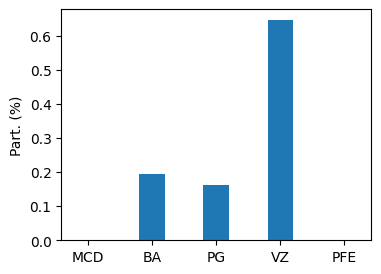

In [126]:
plt.figure(figsize = (4, 3))
plt.bar(activos, x.value/x.value.sum(), width = 0.4)
plt.ylabel("Part. (%)")
plt.show();

In [127]:
ret_port = retornos @ wpt
rpt = ret_port.mean()
sigmapt = ret_port.std()
rpt*12, sigmapt*np.sqrt(12)

(0.12196549481222707, 0.1557875884283272)

b. Calcular el VaR del portafolio para los niveles de confianza del 95% y 99%. Usar el
modelo estándar o paramétrico.

In [128]:
activos = ["MCD","BA","PG","VZ","PFE"] 
precios = yf.download(activos, start="2017-12-01",end="2022-12-31",interval="1Mo")['Adj Close']
retornos = np.log(precios/precios.shift()).dropna()
mu = retornos.mean()
cov = retornos.cov()
sigma = retornos.std()

[*********************100%***********************]  5 of 5 completed


In [129]:
rp = retornos.mean()
sigmap = retornos.std()

alpha = 0.05
 
VaRp = rp - norm.ppf(1-alpha)*sigmap 
VaRp

BA    -0.238158
MCD   -0.081869
PFE   -0.110128
PG    -0.071981
VZ    -0.082451
dtype: float64

In [130]:
rp2 = retornos.mean()
sigmap2 = retornos.std()

alpha2 = 0.01
 
VaRp2 = rp2 - norm.ppf(1-alpha2)*sigmap2 
VaRp2

BA    -0.334145
MCD   -0.119547
PFE   -0.159771
PG    -0.106200
VZ    -0.116149
dtype: float64

c. Calcular el VaR del portafolio para los niveles de confianza del 95% y 99%. Usar el
modelo de estimación histórica.

In [131]:
var_hist = retornos.quantile(0.05)
var_hist

BA    -0.153703
MCD   -0.083980
PFE   -0.108040
PG    -0.087406
VZ    -0.094216
Name: 0.05, dtype: float64

In [132]:
var_hist2 = retornos.quantile(0.01)
var_hist2

BA    -0.413972
MCD   -0.120607
PFE   -0.126801
PG    -0.090615
VZ    -0.103246
Name: 0.01, dtype: float64

d. Utilice el método de Monte Carlo para construir una muestra aleatoria de 10.000
portafolios. Con esta muestra aleatoria calcular el VaR de simulación del portafolio.

In [133]:
port_rand = 10000
weights = np.zeros((port_rand, n))
for i in range(port_rand):
    w = np.random.random(n)
    w = w / np.sum(w)            
    weights[i,:] = w 

In [134]:
t = len(retornos.iloc[:,1])
rand_returns = np.zeros((t,port_rand))
for i in range(port_rand):
  rand_returns[:,i] = retornos @ weights[i,:]

In [135]:
alpha = 0.05
VAR2 = norm.ppf(alpha, rand_returns.mean(), rand_returns.std())
VAR2

-0.08297040947942667

e. ¿Se encuentran diferencias significativas entre el VaR de simulación y el VaR de
paramétrico?

In [136]:
VAR2, VaRp.mean()

(-0.08297040947942667, -0.11691720040455604)

Al hacer la prueba por el método MonteCarlo la media del portafolio VaR es más grande que si se hace por el método paramétrico.

3. Los precios de activos riesgos en el mercado describen un proceso estocástico {St}t≥0 que satisface:

St = S0 exp{(μ– 1/2σ2)dt + σ dWt}

Donde: μ es la tasa de retorno del activo, σ es su volatilidad y Wt es un proceso estándar de
Wiener. A partir de esta expresión es posible simular el precio del activo en algún instante de
tiempo t.

a. Escoja una acción de su preferencia. Con la información histórica con cierre a Dic-2022,estime los parámetros μ y σ. Utilice el método de Monte Carlo para generar una muestra aleatoria de 10.000 posibles valores del precio del activo en el instante t = 1. Presente gráficamente las primeras 20 trayectorias del proceso.
Nota: tome como S0 el precio de Dic-2022 y los parámetros estimados a partir de la muestra de datos.

In [137]:
precios3 = yf.download("VZ", start="2021-12-01",end="2022-12-31",interval="1Mo")['Adj Close']
retornos3 = np.log(precios3/precios3.shift()).dropna()
mu3 = retornos3.mean()

[*********************100%***********************]  1 of 1 completed


In [138]:
retornos3

Date
2022-01-01    0.024148
2022-02-01    0.020208
2022-03-01   -0.052206
2022-04-01   -0.095507
2022-05-01    0.114457
2022-06-01   -0.010584
2022-07-01   -0.094148
2022-08-01   -0.087125
2022-09-01   -0.096339
2022-10-01   -0.015928
2022-11-01    0.058893
2022-12-01    0.010717
Name: Adj Close, dtype: float64

In [139]:
precios3

Date
2021-12-01    47.711239
2022-01-01    48.877392
2022-02-01    49.875168
2022-03-01    47.338192
2022-04-01    43.026272
2022-05-01    48.243824
2022-06-01    47.735897
2022-07-01    43.446724
2022-08-01    39.821632
2022-09-01    36.164253
2022-10-01    35.592785
2022-11-01    37.751900
2022-12-01    38.158672
Name: Adj Close, dtype: float64

In [140]:
def PathsGBM(S0,mu,sigma,T,NS,M):    
    Z = np.random.normal(0.0,1.0,[NS,M])
    S = np.zeros([NS, M+1])
    S[:,0] = S0
    dt = T / M
    for t in range(0,M):
        S[:,t+1] = S[:,t] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) *Z[:,t])
    return S

In [141]:
T= 1 
mu = retornos3.mean()*12
sigma = retornos3.std()*np.sqrt(12)
S0 = 38
NS = 10000 
M = 12 
St = PathsGBM(S0,mu,sigma,T,NS,M)

Text(0.5, 0, 'Tiempo')

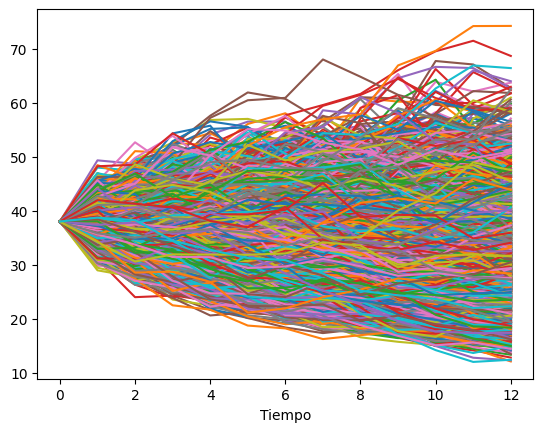

In [142]:
plt.plot(np.transpose(St)) 
plt.xlabel("Tiempo")

In [143]:
T2= 1 
mu2 = retornos3.mean()*12
sigma2 = retornos3.std()*np.sqrt(12)
S02 = 38
NS2 = 20 
M2 = 12 
St2 = PathsGBM(S02,mu2,sigma2,T2,NS2,M2)

Text(0.5, 0, 'Tiempo')

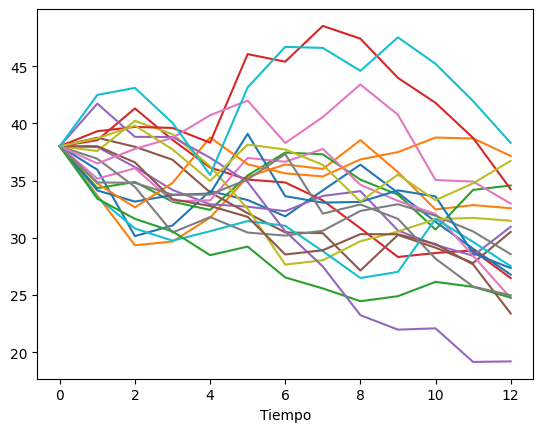

In [144]:
plt.plot(np.transpose(St2)) 
plt.xlabel("Tiempo")

b. Construya el histograma de los precios y retornos al final del periodo (t = 1). ¿qué puede
concluir de la forma de los histogramas?

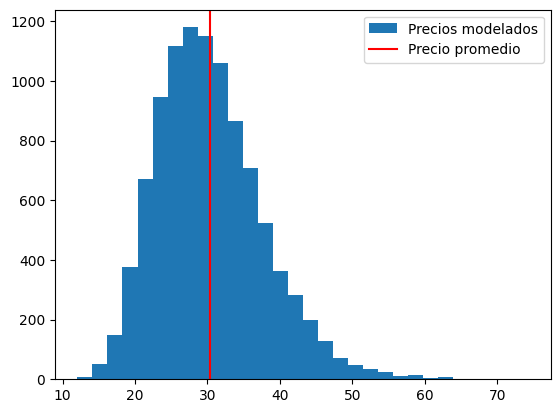

In [145]:
plt.hist(St[:,-1], bins=30, label='Precios modelados')
plt.axvline(St[:,-1].mean(), color='r', label='Precio promedio')
plt.legend();

Del histograma se puede deducir que los precios se distrubuyen de forma normal

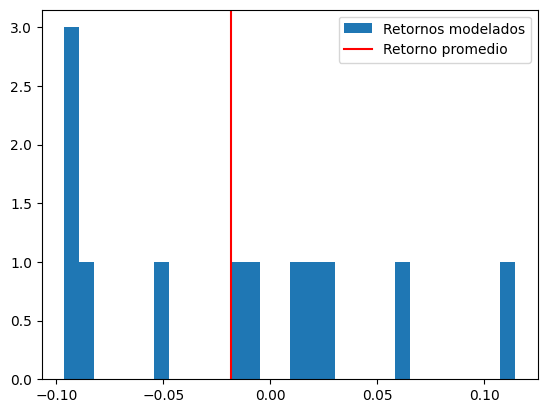

In [146]:
plt.hist(retornos3, bins=30, label='Retornos modelados')
plt.axvline(retornos3.mean(), color='r', label='Retorno promedio')
plt.legend();

c. Demuestre que el valor del precio simulado de la acción en T converge a ST exp{μ T}.

d. Calcule la probabilidad de que el precio de la acción sea inferior a S0.

In [147]:
from scipy.stats import norm 
mu, std = norm.fit(precios)
probabilidad = norm.cdf(38, loc=mu, scale=std)
probabilidad

0.1679030174920807

La probabilidad de que el precio de la acción sea menor al valor de cierre de diciembre de 2022 es de 16.79%

4. Un tipo de proceso estocástico asociados al movimiento Browniano y que se utilizan
ampliamente en finanzas son los llamados procesos de reversión a la media. Dentro de
estos se encuentra el proceso Ornstein-Uhlenbeck, que es un proceso Xt que satisface:

Xt+dt = Xt + (μ–Xt)dt + σ(Wt+dt − Wt)

a. Utilice el método de Monte Carlo para realizar una simulación de 10000 posibles
trayectorias (NS) de este proceso considerando los siguientes valores: X0 = 1, μ = 3, σ = 0. 3, T = 5, NS = 100, dt = T/m. Presente gráficamente los resultados para las primeras
10 trayectorias del proceso.



In [148]:
def PathsOU(X0,mu,sigma,T,NS,M):    
    Z = np.random.normal(0.0,1.0,[NS,M])
    X = np.zeros([NS, M+1])
    X[:,0] = X0
    dt = T / M
    k=1
    std_dt = np.sqrt( sigma**2 /(2*k) * (1-np.exp(-2*k*dt)) )
    for t in range(0,M):
         X[:,t+1] = mu + np.exp(-k*dt)*(X[:,t]-mu) + std_dt * Z[:,t]
    return X

In [149]:
T = 5 
mu = 3*12
sigma = 0.3*np.sqrt(12)
X0 = 1
NS = 100#Número de trayectorias
M = 60 # Partición del año en meses/días
Xt = PathsOU(X0,mu,sigma,T,NS,M)

Xt

array([[ 1.        ,  3.30983188,  5.73898495, ..., 36.17243043,
        36.58125   , 36.62740331],
       [ 1.        ,  3.62194902,  6.26921119, ..., 33.7605019 ,
        33.82899626, 33.96832107],
       [ 1.        ,  3.55219935,  6.36173979, ..., 35.18269942,
        35.15765864, 35.25733193],
       ...,
       [ 1.        ,  3.92006703,  6.40151999, ..., 35.43178187,
        35.41778665, 35.66432803],
       [ 1.        ,  3.5744869 ,  5.9720647 , ..., 34.81326085,
        34.7907786 , 34.64594466],
       [ 1.        ,  3.85506984,  6.78265936, ..., 36.32211173,
        36.11693597, 35.56875964]])

Text(0.5, 0, 'Tiempo')

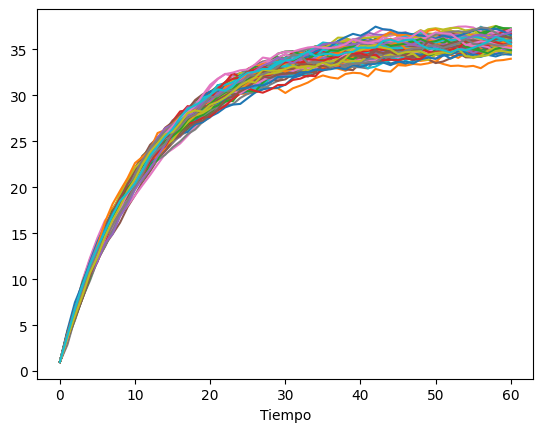

In [150]:
plt.plot(np.transpose(Xt)) 
plt.xlabel("Tiempo")

In [151]:
T2 = 5 
mu2 = 3*12
sigma2 = 0.3*np.sqrt(12)
X02 = 1
NS2 = 10
M2 = 60 
Xt2 = PathsOU(X02,mu2,sigma2,T2,NS2,M2)

Xt2

array([[ 1.        ,  3.79191901,  6.26946666,  8.44890794, 10.56045634,
        12.3343606 , 13.72002111, 15.95523657, 17.78800455, 19.27717261,
        20.29815001, 21.16535052, 22.69810284, 24.15611635, 25.4405929 ,
        25.85653387, 26.7258136 , 27.22645217, 28.37272106, 29.20722687,
        29.33656152, 29.59091365, 29.83166212, 30.23022142, 31.05039443,
        31.57870013, 32.09629725, 32.69741344, 32.98438066, 33.71946886,
        33.84142847, 34.28622735, 34.61255087, 33.90667702, 34.08776141,
        33.94916621, 34.32428179, 35.09536459, 35.37112453, 35.07020626,
        34.70391184, 34.35879594, 34.59048204, 34.81120206, 34.71287193,
        35.05278944, 35.11282539, 35.3425005 , 35.27719989, 35.01318805,
        35.14774401, 35.40416012, 35.51654974, 35.81234753, 35.67219996,
        35.82195625, 36.05559543, 36.38184924, 36.05272337, 36.58783283,
        36.93244152],
       [ 1.        ,  4.44295846,  7.05576825,  9.13954268, 11.04335745,
        13.19731026, 14.90460

Text(0.5, 0, 'Tiempo')

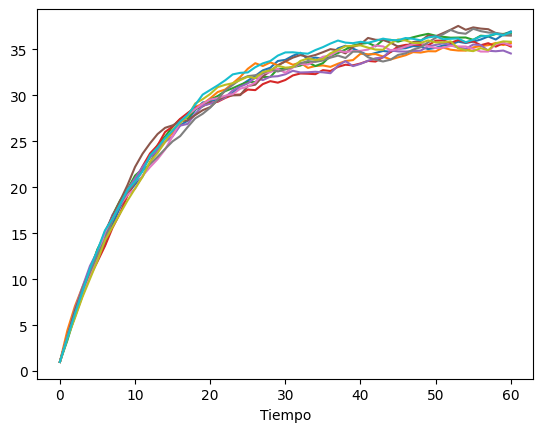

In [152]:
plt.plot(np.transpose(Xt2)) 
plt.xlabel("Tiempo")

b. A partir de los observado en las simulaciones realizadas en el punto anterior, ¿qué puede
concluir acerca del valor esperado y la varianza del proceso Ornstein-Uhlenbeck en el largo
plazo?

In [153]:
k=1
mean_T = mu + np.exp(-k*T) * (X0-mu) 
std_T = np.sqrt( sigma**2 /(2*k) * (1-np.exp(-2*k*T)) )
mean_T, std_T

(35.76417185503201, 0.7348302416462785)

Se observa que a largo plazo, las trayectorías van a mantenerse constantes, y esto se pude comprobar con el resultado de su valor esperado. Adicionalmente, la varianza no es muy grando, es decir, que no hay mucha volatidad a largo plazo

c. De acuerdo con la ecuación 1, ¿cuál es la distribución de probabilidad del proceso
Ornstein-Uhlenbeck?

El proceso Ornstein-Uhlenbeck es Gaussiano, Markoviano y tambíen incondicionalmente estacionario

d. El proceso Ornstein-Uhlenbeck se suelen utilizar para modelar la dinámica de la tasa
corta de interés. Por ejemplo, si rt denota el valor de la tasa corte de interés en el mercado,
esta se puede modelar como:

rt+dt = rt + (μ– rt)dt + σ(Wt+dt − Wt)

Teniendo en cuenta los siguientes parámetros: r0 = 0. 03, μ = 0. 05, σ = 0. 15, T = 1, NS = 100, dt = T/m; simule 100 posibles valores de la tasa de corta en el instante T = 1, y utilice el valor promedio obtenido para valorar un bono cero cupón y facial 100 con vencimiento en T. Presente gráficamente los resultados para las primeras 10 trayectorias del proceso.

In [154]:
r0 = 0.03  
mu = 0.05  
sigma = 0.15  
T = 1  
NS = 100  
m = 360 
dt = T/m  

r = np.zeros((NS, m+1))  
r[:,0] = r0  
for i in range(NS):
    for j in range(m):
        r[i,j+1] = r[i,j] + (mu - r[i,j])*dt + sigma*np.random.normal()*np.sqrt(dt)


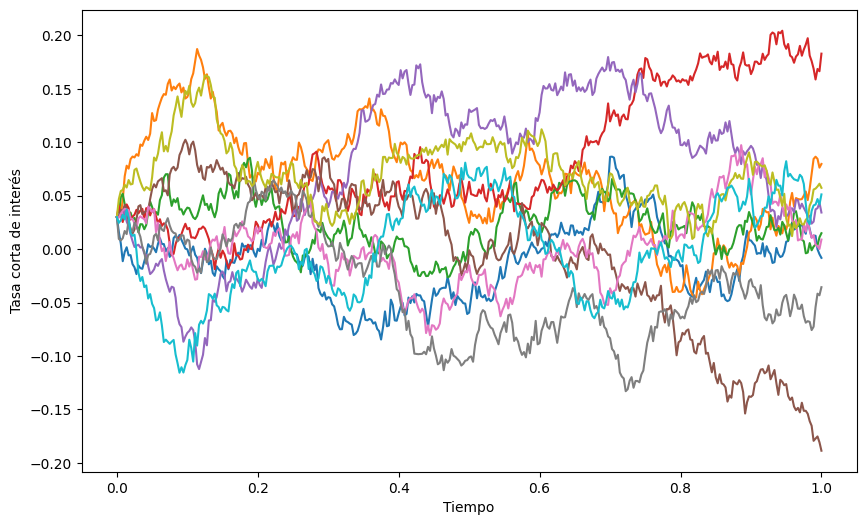

In [155]:
plt.figure(figsize=(10,6))
for i in range(10):
    plt.plot(np.linspace(0,T,m+1), r[i,:], label=f"Trayectoria {i+1}")
plt.xlabel("Tiempo")
plt.ylabel("Tasa corta de interés")
plt.show()

In [156]:
P = np.exp(-r[:, -1]*T)*100
print(f"El precio del bono cero cupón es: {np.mean(P):.2f}")

El precio del bono cero cupón es: 97.30


El precio esperado (96.16) es menor al facial (100).

5. Escoja tres de los siguientes activos.

i. Gold futures (GC=F)

ii. Brent Oil futures (BZ=F)

iii. US Treasury Bill (^IRX)

iv. EURUSD currency (EURUSD=X)

v. GBPUSD currency (GBPUSD=X)

vi. Coffee futures (KC=F)

vii. Natural gas (NG=F)

viii. Cooper (HG=F)

Con la información de las series históricas para el periodo 2005-01-01 a 2022-12-31 con
periodicidad mensual, construya 100 trayectorias o simulaciones para cada serie para el año 2023. Para este ejercicio tenga en cuenta que las series pueden seguir un proceso
estocástico tipo MGB o de reversión a la media tipo OU.

La selección del proceso debe incorporar:

a. La gráfica de las series históricas de los precios

b. Los resultados de las pruebas de estacionariedad de Dickey-Fuller (ADF)


c. Los resultados de la simulación

[*********************100%***********************]  1 of 1 completed


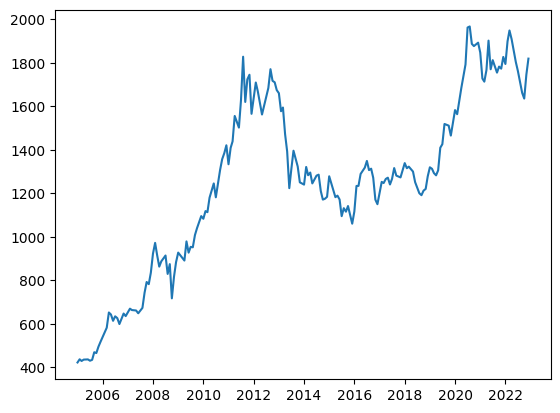

In [157]:
activos = "GC=F" 
precios5 = yf.download(activos, start='2005-01-01', end='2022-12-31', interval='1Mo')['Adj Close'].dropna()
retornos5 = np.log(precios5/precios5.shift()).dropna()
plt.plot(precios5)

In [158]:
pruebadf1 = adfuller(precios5)  
print("ADF test: %f" % pruebadf1[0]) 
print("P-value: %f" % pruebadf1[1])
print("Citical values:")
for key, value in pruebadf1[4].items():
  print("\t%s: %f" %(key,value))

ADF test: -1.606097
P-value: 0.480530
Citical values:
	1%: -3.466398
	5%: -2.877380
	10%: -2.575214


In [159]:
def PathsGBM(S0,mu,sigma,T,NS,M):    
    Z = np.random.normal(0.0,1.0,[NS,M])
    S = np.zeros([NS, M+1])
    S[:,0] = S0
    dt = T / M
    for t in range(0,M):
        S[:,t+1] = S[:,t] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) *Z[:,t])
    return S

In [160]:
T = 1 
mu = retornos5.mean()*12
sigma = retornos5.std()*np.sqrt(12)
S0 = 100
NS = 100
M = 12 
St = PathsGBM(S0,mu,sigma,T,NS,M)
St

array([[100.        , 102.82138945, 114.19910603, ..., 137.36420946,
        127.10324556, 117.84555051],
       [100.        ,  96.36067389,  89.14705558, ...,  88.10465131,
         88.03160346,  82.20460548],
       [100.        , 103.51454632, 108.55542377, ..., 104.72963294,
        105.37260281, 109.95303764],
       ...,
       [100.        , 101.66530909, 109.07546665, ..., 130.14282156,
        133.24121169, 125.99195662],
       [100.        , 107.83959923, 120.36567957, ..., 165.96735545,
        175.74772799, 194.08987944],
       [100.        ,  97.09496464,  99.14960366, ..., 125.1277412 ,
        127.33150535, 122.78773045]])

[*********************100%***********************]  1 of 1 completed


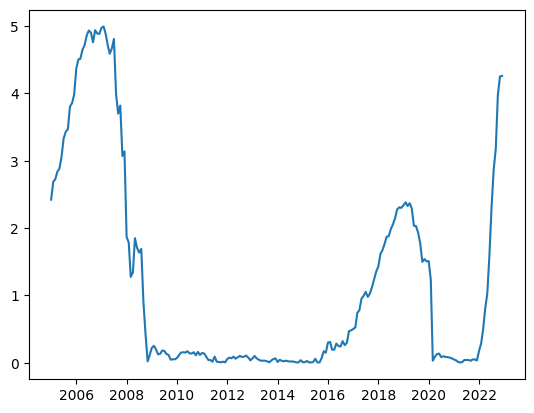

In [161]:
activos = "^IRX" 
precios5 = yf.download(activos, start='2005-01-01', end='2022-12-31', interval='1Mo')['Adj Close'].dropna()
retornos5 = np.log(precios5/precios5.shift()).dropna()
plt.plot(precios5)

In [162]:
pruebadf1 = adfuller(precios5)  
print("ADF test: %f" % pruebadf1[0]) 
print("P-value: %f" % pruebadf1[1])
print("Citical values:")
for key, value in pruebadf1[4].items():
  print("\t%s: %f" %(key,value))

ADF test: -2.013092
P-value: 0.280862
Citical values:
	1%: -3.461879
	5%: -2.875404
	10%: -2.574159


In [163]:
def PathsGBM(S0,mu,sigma,T,NS,M):    
    Z = np.random.normal(0.0,1.0,[NS,M])
    S = np.zeros([NS, M+1])
    S[:,0] = S0
    dt = T / M
    for t in range(0,M):
        S[:,t+1] = S[:,t] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) *Z[:,t])
    return S

In [164]:
T = 1 
mu = retornos5.mean()*12
sigma = retornos5.std()*np.sqrt(12)
S0 = 100
NS = 100
M = 12 
St = PathsGBM(S0,mu,sigma,T,NS,M)
St

array([[1.00000000e+02, 1.06762475e+02, 1.76306473e+01, ...,
        2.55544299e-01, 2.07854973e-01, 1.92235807e-01],
       [1.00000000e+02, 1.62970390e+01, 6.72595491e+00, ...,
        8.69644233e-01, 3.54790704e-01, 1.43699681e-01],
       [1.00000000e+02, 5.96195878e+01, 2.39087441e+01, ...,
        7.60915893e-01, 3.62033396e-01, 2.03671091e-01],
       ...,
       [1.00000000e+02, 7.20151988e+01, 5.89866289e+01, ...,
        2.69937408e+01, 1.38758713e+01, 6.60318978e+00],
       [1.00000000e+02, 7.16491618e+01, 2.86689872e+01, ...,
        8.34683207e+00, 5.59432397e+00, 6.89386278e+00],
       [1.00000000e+02, 1.85083625e+02, 5.48219188e+01, ...,
        7.65749847e+00, 2.56955204e+00, 6.65693760e-01]])

[*********************100%***********************]  1 of 1 completed


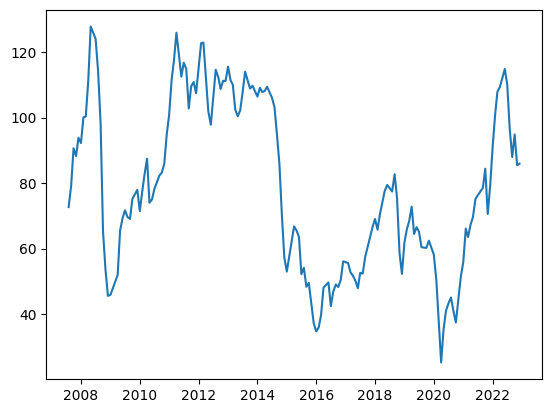

In [165]:
activos = "BZ=F" 
precios5 = yf.download(activos, start='2005-01-01', end='2022-12-31', interval='1Mo')['Adj Close'].dropna()
retornos5 = np.log(precios5/precios5.shift()).dropna()
plt.plot(precios5)

In [166]:
pruebadf1 = adfuller(precios5)  
print("ADF test: %f" % pruebadf1[0]) 
print("P-value: %f" % pruebadf1[1])
print("Citical values:")
for key, value in pruebadf1[4].items():
  print("\t%s: %f" %(key,value))

ADF test: -2.497247
P-value: 0.116146
Citical values:
	1%: -3.472703
	5%: -2.880132
	10%: -2.576683


In [167]:
def PathsGBM(S0,mu,sigma,T,NS,M):    
    Z = np.random.normal(0.0,1.0,[NS,M])
    S = np.zeros([NS, M+1])
    S[:,0] = S0
    dt = T / M
    for t in range(0,M):
        S[:,t+1] = S[:,t] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) *Z[:,t])
    return S

In [168]:
T = 1 
mu = retornos5.mean()*12
sigma = retornos5.std()*np.sqrt(12)
S0 = 100
NS = 100
M = 12 
St = PathsGBM(S0,mu,sigma,T,NS,M)
St

array([[100.        ,  99.81699081,  96.40342202, ...,  72.24618658,
         73.02979164,  68.60997639],
       [100.        , 103.07928621, 103.46683636, ...,  79.48038771,
         70.06980823,  83.07738823],
       [100.        ,  95.84405753,  84.21500377, ...,  68.75480234,
         72.78466871,  82.95594036],
       ...,
       [100.        ,  94.91125113, 118.32671792, ...,  55.60570229,
         60.32817617,  65.74790612],
       [100.        ,  94.62431374,  94.29293625, ...,  53.658818  ,
         69.9580892 ,  62.96478257],
       [100.        , 123.66165745, 117.89783451, ..., 124.24910419,
        118.3174496 , 132.64091407]])